# INTELIGENCIA ARTIFICIAL - EVALUACIÓN 3¶

Integrantes: Sebastian Racedo y Sebastian Valle

Primero importaremos las librerias que necesitarems para llevar a cabo la implementación de nuestro algoritmo.

* Usaremos la libreria numpy para las operaciones con matrices
* Usaremos la libreria matplotlib para graficar
* Usaremos la libreria random para diferentes operaciones que requieren numeros al azar dentro de un rango 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

Creamos la población que sera usada como "base" o la población inicial que entrera al algoritmo

In [2]:
def generate_initial_population(population_size, num_disks, num_towers=3):
    population = []
    for i in range(population_size):
        specimen = []
        min_length = 2 ** num_disks - 1
        # We allow for a slack of 50 movements after the optimum.
        max_length = min_length + 50
        specimen_size = random.randint(min_length, max_length)

        while len(specimen) < specimen_size:
            origin_tower = random.randint(1, num_towers)
            
            if len(specimen) == 0:
                origin_tower = 1
                
            destination_tower = random.randint(1, num_towers)
            # Don't perform bogus movements
            if origin_tower == destination_tower:
                continue
                
            element = (origin_tower, destination_tower)
            specimen.append(element)
            
        population.append(specimen)
    return population

In [3]:
def fitness(specimen, num_disks, print_state=lambda x: None):
    # We must play out the game to verify valid movements.
    state = [[i + 1 for i in range(num_disks)], [], []]
    print_state(state)
    
    fitness_value = 0
    for movement in specimen:
        origin_tower = movement[0] - 1
        destination_tower = movement[1] - 1
        
        # We ignore invalid movements and try to play out those that can be played.
        
        if len(state[origin_tower]) == 0:
            # Can't move from an empty tower, invalid movement.
            fitness_value = fitness_value - 5
            continue
        
        origin_peg = state[origin_tower][0]
        if len(state[destination_tower]) > 0 and state[destination_tower][0] < origin_peg:
            # Can't place a bigger peg on top of a smaller one, invalid movement.
            fitness_value = fitness_value - 5
            continue
            
        state[origin_tower].pop(0)
        state[destination_tower].insert(0, origin_peg)
        print_state(state)
        
        if len(state[1]) == num_disks or len(state[2]) == num_disks:
            # This is a successful run, grant a high amount of fitness
            fitness_value = fitness_value + 10000
            break
        
        fitness_value = fitness_value + 1
    
    # Penalize the specimen by the amount of pegs still remaining in the starting tower
    fitness_value = fitness_value - len(state[0]) * 10
    # Penalize the specimen by the number of movements it made
    fitness_value = fitness_value - len(specimen)
    
    fitness_value = fitness_value + len(state[2]) * 5
    fitness_value = fitness_value + sum(state[2]) * 8
    fitness_value = fitness_value - sum(state[0]) * 15
    fitness_value = fitness_value - len(state[1]) * 5
    
    
    if len(state[2]) and state[2][-1] == num_disks:
        fitness_value = fitness_value + 400
    return fitness_value

In [4]:
def crossover(parents, population_len, num_disks):
    for i in range(population_len - 1):
        specimen = []
        while len(specimen) < 2 ** num_disks - 1:
            # Generate a new specimen by combining random parents
            parent_1, parent_2 = random.sample(parents, 2)

            parent_1_split = len(parent_1) // 2
            parent_2_split = len(parent_2) // 2
            
            part_1 = parent_1[:parent_1_split]
            part_2 = parent_2[parent_2_split:]
            
            random.shuffle(part_2)
            
            specimen = part_1
            specimen.extend(part_2)
        
        population.append(specimen)
    return population

In [5]:
def mutate(population, mutation_rate):
    for specimen in population:
        specimen_len = len(specimen)
        mutable_genes = random.randint(1, specimen_len)
        for gene in range(mutable_genes):
            if random.uniform(0, 1) >= mutation_rate:
                continue

            index = random.randint(1, specimen_len - 1)

            origin_tower = 0
            destination_tower = 0

            while origin_tower == destination_tower:
                origin_tower = random.randint(1, 3)
                destination_tower = random.randint(1, 3)

            element = (origin_tower, destination_tower)

            specimen[index] = element
    return population

In [6]:
num_disks = 5
population_size = 1000
crossover_parents_len = 10
new_specimens_size = 20 # How many completely new specimens to introduce into the gene pool after each generation
num_generations = 40
mutation_rate = 0.50 + num_disks / 15
population = generate_initial_population(population_size, num_disks)
#population

In [7]:
len(population)

1000

In [8]:
generational_fitness = []

for generation in range(num_generations):
    population_fitness = [fitness(specimen, num_disks) for specimen in population]
    #print('Generation {} population fitness'.format(generation))
    #print(population_fitness)

    population_fitness, population = zip(*sorted(zip(population_fitness, population), reverse=True))

    population = list(population)
    
    best_index = np.argmax(population_fitness)
    best_specimen = copy.deepcopy(population[best_index])
    best_fitness = fitness(best_specimen, num_disks)
    generational_fitness.append(best_fitness)
    print('Generation {} best index: {}. Fitness: {}'.format(generation, best_index, best_fitness))
    print('Generation {} best specimen'.format(generation))
    print(population[best_index])
    print('Generation {} best specimen final state'.format(generation))
    fitness(best_specimen, num_disks, lambda x: print(x))
    
    # Select only the best parents to breed the next generation
    parents = population[:crossover_parents_len]
    
    # Create the new population
    population = crossover(parents, population_size - new_specimens_size - 1, num_disks)
    # Mutate the new population
    population = mutate(population, mutation_rate)
    
    # The best specimen in the whole population will be inherited as-is into the next generation.
    # This ensures the fitness curve never decreases
    population.append(best_specimen)
    
    # Introduce new, fresh specimens into the gene pool
    new_specimens = generate_initial_population(new_specimens_size, num_disks)
    population.extend(new_specimens)

Generation 0 best index: 0. Fitness: 225
Generation 0 best specimen
[(1, 3), (1, 2), (3, 1), (1, 2), (1, 3), (1, 3), (1, 3), (3, 2), (3, 1), (1, 3), (1, 3), (2, 1), (1, 2), (1, 3), (2, 3), (3, 2), (2, 1), (2, 3), (2, 1), (2, 3), (1, 3), (2, 1), (1, 3), (1, 3), (1, 3), (2, 1), (1, 2), (3, 2), (3, 1), (2, 3), (1, 3), (1, 3), (3, 2), (2, 3), (3, 1), (3, 1), (3, 2), (3, 1), (1, 3), (1, 2), (2, 1), (1, 3), (2, 1), (1, 3), (1, 2), (3, 1), (3, 2), (3, 2), (1, 2), (3, 2), (1, 2), (2, 1), (1, 2), (1, 2), (3, 1), (3, 1), (3, 1), (3, 2), (3, 2), (1, 3), (1, 3), (2, 1)]
Generation 0 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[1, 3, 4, 5], [2], []]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5

Generation 6 best index: 0. Fitness: 282
Generation 6 best specimen
[(1, 3), (1, 2), (1, 3), (1, 3), (3, 2), (1, 3), (1, 2), (2, 1), (1, 2), (1, 2), (2, 3), (3, 1), (2, 3), (2, 3), (1, 3), (2, 1), (2, 1), (1, 2), (3, 1), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 1), (3, 2), (3, 1), (1, 2), (3, 2), (2, 1), (1, 2), (2, 1), (2, 1), (1, 3), (2, 1), (3, 2), (3, 1), (3, 2), (2, 1), (1, 3), (1, 2), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 2), (3, 1), (2, 1), (1, 2), (2, 1), (1, 2), (1, 2), (1, 3), (1, 3), (2, 1), (1, 3), (3, 2), (1, 3), (3, 1), (3, 2), (1, 3), (2, 3), (1, 2), (2, 1)]
Generation 6 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2

Generation 11 best index: 0. Fitness: 282
Generation 11 best specimen
[(1, 3), (1, 2), (1, 3), (1, 3), (3, 2), (1, 3), (1, 2), (2, 1), (1, 2), (1, 2), (2, 3), (3, 1), (2, 3), (2, 3), (1, 3), (2, 1), (2, 1), (1, 2), (3, 1), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 1), (3, 2), (3, 1), (1, 2), (3, 2), (2, 1), (1, 2), (2, 1), (2, 1), (1, 3), (2, 1), (3, 2), (3, 1), (3, 2), (2, 1), (1, 3), (1, 2), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 2), (3, 1), (2, 1), (1, 2), (2, 1), (1, 2), (1, 2), (1, 3), (1, 3), (2, 1), (1, 3), (3, 2), (1, 3), (3, 1), (3, 2), (1, 3), (2, 3), (1, 2), (2, 1)]
Generation 11 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[1, 5], [4], [2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5],

Generation 17 best index: 0. Fitness: 407
Generation 17 best specimen
[(1, 3), (1, 2), (1, 3), (2, 3), (3, 2), (1, 3), (3, 2), (2, 1), (1, 2), (1, 3), (2, 3), (3, 1), (2, 3), (2, 3), (2, 1), (1, 3), (1, 3), (1, 2), (3, 2), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 1), (3, 2), (2, 3), (3, 2), (1, 3), (2, 1), (1, 2), (3, 2), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (1, 3), (2, 3), (3, 1), (1, 3), (2, 1), (2, 3), (2, 1), (3, 1), (1, 3), (1, 2), (2, 1), (3, 1), (2, 1), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (2, 3), (1, 2)]
Generation 17 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[

Generation 23 best index: 0. Fitness: 407
Generation 23 best specimen
[(1, 3), (1, 2), (1, 3), (2, 3), (3, 2), (1, 3), (3, 2), (2, 1), (1, 2), (1, 3), (2, 3), (3, 1), (2, 3), (2, 3), (2, 1), (1, 3), (1, 3), (1, 2), (3, 2), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 1), (3, 2), (2, 3), (3, 2), (1, 3), (2, 1), (1, 2), (3, 2), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (1, 3), (2, 3), (3, 1), (1, 3), (2, 1), (2, 3), (2, 1), (3, 1), (1, 3), (1, 2), (2, 1), (3, 1), (2, 1), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (2, 3), (1, 2)]
Generation 23 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[

Generation 29 best index: 0. Fitness: 407
Generation 29 best specimen
[(1, 3), (1, 2), (1, 3), (2, 3), (3, 2), (1, 3), (3, 2), (2, 1), (1, 2), (1, 3), (2, 3), (3, 1), (2, 3), (2, 3), (2, 1), (1, 3), (1, 3), (1, 2), (3, 2), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 1), (3, 2), (2, 3), (3, 2), (1, 3), (2, 1), (1, 2), (3, 2), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (1, 3), (2, 3), (3, 1), (1, 3), (2, 1), (2, 3), (2, 1), (3, 1), (1, 3), (1, 2), (2, 1), (3, 1), (2, 1), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (2, 3), (1, 2)]
Generation 29 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[

Generation 35 best index: 0. Fitness: 407
Generation 35 best specimen
[(1, 3), (1, 2), (1, 3), (2, 3), (3, 2), (1, 3), (3, 2), (2, 1), (1, 2), (1, 3), (2, 3), (3, 1), (2, 3), (2, 3), (2, 1), (1, 3), (1, 3), (1, 2), (3, 2), (1, 2), (3, 1), (2, 3), (1, 2), (2, 1), (3, 1), (3, 2), (2, 3), (3, 2), (1, 3), (2, 1), (1, 2), (3, 2), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (1, 3), (2, 3), (3, 1), (1, 3), (2, 1), (2, 3), (2, 1), (3, 1), (1, 3), (1, 2), (2, 1), (3, 1), (2, 1), (2, 3), (2, 1), (1, 2), (1, 3), (3, 2), (2, 3), (1, 2)]
Generation 35 best specimen final state
[[1, 2, 3, 4, 5], [], []]
[[2, 3, 4, 5], [], [1]]
[[3, 4, 5], [2], [1]]
[[3, 4, 5], [1, 2], []]
[[4, 5], [1, 2], [3]]
[[1, 4, 5], [2], [3]]
[[4, 5], [1, 2], [3]]
[[4, 5], [2], [1, 3]]
[[1, 4, 5], [2], [3]]
[[1, 4, 5], [], [2, 3]]
[[4, 5], [], [1, 2, 3]]
[[5], [4], [1, 2, 3]]
[[5], [1, 4], [2, 3]]
[[2, 5], [1, 4], [3]]
[[2, 5], [4], [1, 3]]
[[5], [2, 4], [1, 3]]
[[2, 5], [4], [1, 3]]
[[1, 2, 5], [4], [3]]
[[1, 2, 5], [3, 4], []]
[

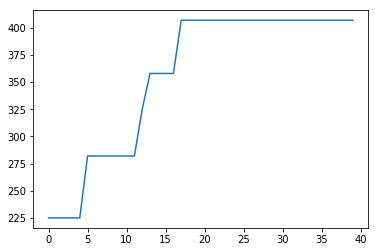

In [9]:
plt.plot(generational_fitness)
plt.show()